# Wisconsin Diagnostic Breast Cancer (WDBC) Data Analysis 

In this notebook, we are analyzing data from breast cancer research to predict if a breast mass is begign or malignant. We have total 569 data points and 32 attributes. The first attribute is an ID column, second is our target variable and rest 30 are features of the mass, computed from a digitized image of a fine needle aspirate (FNA). The target class distribution for these sample points is 357 benign and 212 malignant.

We start by importing all necessary libraries for our analysis.

In [1]:
# importing all necessary libraries
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, tree, linear_model
from sklearn import datasets, preprocessing, metrics
from sklearn.model_selection import train_test_split

We then use pandas dataframe to load data in a python dataframe, giving column names as specified in the data dictionary. Out of the 30 features of the mass, first 10 attributs are mean, next 10 are standard errors, and the last 10 are the "worst" or largest values. The 10 features are:

    a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)
    
All feature values are recoded with four significant digits.

In [4]:
# load entire data in one numpy array
wdbc_raw = pd.read_csv('wdbc.data', delimiter=",", names=[
        'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 
        'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
        'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
        'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 
        'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 
        'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 
        'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
        'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'])

Here, we are converting the pandas dataframe to a numpy array, as all data analysis is done using scikit learn, which is based on numpy. Doing this makes our analysis simpler.

In [5]:
# convert to numpy array
wdbc_raw = wdbc_raw.to_numpy()

## Training Testing Split

We then divide our data into training, validation and testing splits. The ratio of data being used is 80% training and 20% testing. Out of the 80% training, we again split 80% for training and the rest 20% for validation. The training and validation splits are used to train the model and select the best setting of hyperparameters. Once we have this setting, traning and validation splits are recombined to form a single training dataset used to train our prediction model. The final testing split, which the model has not seen as of now is being used to evaluate the final model performance.

In [6]:
# divide data into training, validation and testing

wdbc_x = wdbc_raw[:, 2:].copy()
wdbc_y = wdbc_raw[:, 1:2].copy()

#_train_2 variables are combination of training and validation splits, 
#to be used for model training after finding the best model
wdbc_x_train_2, wdbc_x_test, wdbc_y_train_2, wdbc_y_test = train_test_split(
                                          wdbc_x, wdbc_y, test_size=0.2, random_state=4)
wdbc_x_train, wdbc_x_val, wdbc_y_train, wdbc_y_val = train_test_split(
                                          wdbc_x_train_2, wdbc_y_train_2, test_size=0.2, random_state=4)

wdbc_y_train_2 = wdbc_y_train_2.ravel()
wdbc_y_test = wdbc_y_test.ravel()
wdbc_y_train = wdbc_y_train.ravel()
wdbc_y_val = wdbc_y_val.ravel()

#see sample division of training, validation and testing
print("Sample count of training and validation combined: ", wdbc_y_train_2.shape[0])
print("Sample count of only training: ", wdbc_y_train.shape[0])
print("Sample count of only validation: ", wdbc_y_val.shape[0])
print("Sample count of testing: ", wdbc_y_test.shape[0])

Sample count of training and validation combined:  455
Sample count of only training:  364
Sample count of only validation:  91
Sample count of testing:  114


## Benchmark

We are now calculating model performance for the following model, where we are predicting everything as 'M'(we are interested in Malign diagnosis rather than benign, although the benign class is majority), and set it as a benchmark to see compare our final model performance.

We will use the F-measure for hyperparameter setting and final model selection, as it is a combination of precision and recall, and we want to maximize these measures for class 'M'

In [76]:
pred = np.full(wdbc_y_test.shape, 'M')

print("Accuracy for this model: ", metrics.accuracy_score(wdbc_y_test, pred))
print("Precision for class M: ", metrics.precision_score(wdbc_y_test, pred, pos_label='M'))
print("Recall for class M: ", metrics.recall_score(wdbc_y_test, pred, pos_label='M'))
print("F-score for this model: ", metrics.f1_score(wdbc_y_test, pred, pos_label='M'))
print("Confusion Matrix for this model: \n", metrics.confusion_matrix(wdbc_y_test, pred))

Accuracy for this model:  0.2982456140350877
Precision for class M:  0.2982456140350877
Recall for class M:  1.0
F-score for this model:  0.45945945945945943
Confusion Matrix for this model: 
 [[ 0 80]
 [ 0 34]]


## KNN

We start by normalizing the dataset, so that the distances calculated in KNN are not overweighed by a feature that has higher range as compared to others. Here, we use the min max normalizing technique.

In [77]:
# normalize train and validation
min_max_scaler = preprocessing.MinMaxScaler()
wdbc_x_train_minmax = min_max_scaler.fit_transform(wdbc_x_train)
wdbc_x_val_minmax = min_max_scaler.transform(wdbc_x_val)

We now check KNN prediction model for different settings of K, specifically from 1 to 99. The final K selection is based on the max F-measure we get. If there are multiple K for this setting, we chose the lowest one, as this would decrease the complexity and computational time of our model.

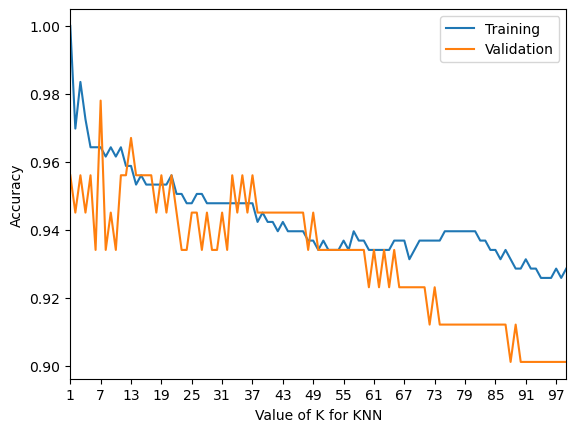

In [78]:
f_scores_knn_train = np.array([])
f_scores_knn_val = np.array([])
accuracy_knn_train = np.array([])
accuracy_knn_val = np.array([])


# running knn for n from 1 to 100
for n_neighbors in range(1, 100):
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    clf = clf.fit(wdbc_x_train_minmax, wdbc_y_train)
    pred_train = clf.predict(wdbc_x_train_minmax)
    pred_val = clf.predict(wdbc_x_val_minmax)
    f_scores_knn_train = np.append(f_scores_knn_train, metrics.f1_score(wdbc_y_train, pred_train, pos_label='M'))
    f_scores_knn_val = np.append(f_scores_knn_val, metrics.f1_score(wdbc_y_val, pred_val, pos_label='M'))
    accuracy_knn_train = np.append(accuracy_knn_train, metrics.accuracy_score(wdbc_y_train, pred_train))
    accuracy_knn_val = np.append(accuracy_knn_val, metrics.accuracy_score(wdbc_y_val, pred_val))

plt.plot(range(1, 100), accuracy_knn_train, label="Training")
plt.plot(range(1, 100), accuracy_knn_val, label="Validation")
plt.xlim(1,99)
plt.xticks(range(1,100,6))
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy')
plt.legend()

We now check the most optimal K as per above discussion. As we can see from the graph any K less than 7 does not optimize our F-score on validation dataset, hence the model is underfitted in this scenario. When increasing complexity, we see that the performance on training and testing remains comparable (with validation usually lesser than training, as expected). At larger values of k, the model fails to capture the local structure, which is why the accuracy further decreases. However at larger values of K, we see that the performance of validation dataset is much lower than the training. This depicts a case of overfitting.

In [79]:
k_optimal = np.where(f_scores_knn_val == f_scores_knn_val.max())[0][0] + 1

print("Optimal value of K based on F-score: ", k_optimal)

Optimal value of K based on F-score:  7


Now, we calculate all our performance metrics on the validation dataset for the above value of optimal K.

In [80]:
clf = neighbors.KNeighborsClassifier(k_optimal)
clf = clf.fit(wdbc_x_train_minmax, wdbc_y_train)
pred = clf.predict(wdbc_x_val_minmax)

print("Accuracy for this model: ", metrics.accuracy_score(wdbc_y_val, pred))
print("Precision for class M: ", metrics.precision_score(wdbc_y_val, pred, pos_label='M'))
print("Recall for class M: ", metrics.recall_score(wdbc_y_val, pred, pos_label='M'))
print("F-score for this model: ", metrics.f1_score(wdbc_y_val, pred, pos_label='M'))
print("Confusion Matrix for this model: \n", metrics.confusion_matrix(wdbc_y_val, pred))

Accuracy for this model:  0.978021978021978
Precision for class M:  1.0
Recall for class M:  0.9444444444444444
F-score for this model:  0.9714285714285714
Confusion Matrix for this model: 
 [[55  0]
 [ 2 34]]


## Decision Tree

We now take a look at decision tree. Similar to KNN we build different decision trees, and select the best one on basis of f-score and then least complexity, in case of a tie. Here we iterate on the basis of depth of tree in the range 1 to 15 inclusive. We also set some hyperparameters like min_impurity_decrease and min_samples_leaf to stop the tree from splitting where the information gain is not much, and avoid the scenarios of overfitting.

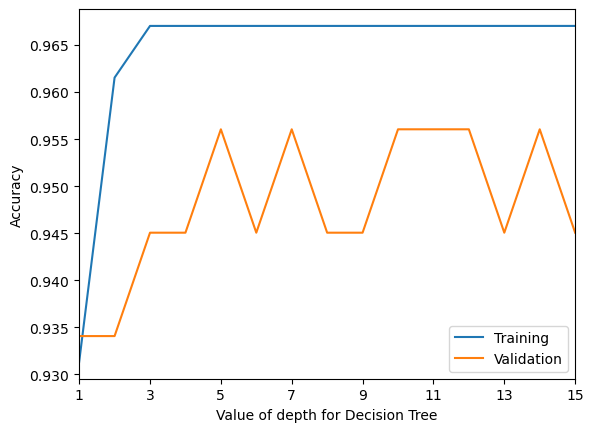

In [115]:
f_scores_dec_tree_train = np.array([])
f_scores_dec_tree_val = np.array([])
accuracy_dec_tree_train = np.array([])
accuracy_dec_tree_val = np.array([])

# running decision tree for max depth from 1 to 15
for md in range(1, 16):
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=md, 
                                      min_impurity_decrease=0.001, min_samples_leaf=10)
    clf = clf.fit(wdbc_x_train, wdbc_y_train)
    pred_train = clf.predict(wdbc_x_train)
    pred_val = clf.predict(wdbc_x_val)
    f_scores_dec_tree_train = np.append(f_scores_dec_tree_train, 
                                        metrics.f1_score(wdbc_y_train, pred_train, pos_label='M'))
    f_scores_dec_tree_val = np.append(f_scores_dec_tree_val, 
                                      metrics.f1_score(wdbc_y_val, pred_val, pos_label='M'))
    accuracy_dec_tree_train = np.append(accuracy_dec_tree_train, 
                                        metrics.accuracy_score(wdbc_y_train, pred_train))
    accuracy_dec_tree_val = np.append(accuracy_dec_tree_val, 
                                      metrics.accuracy_score(wdbc_y_val, pred_val))

plt.plot(range(1, 16), accuracy_dec_tree_train, label="Training")
plt.plot(range(1, 16), accuracy_dec_tree_val, label="Validation")
plt.xlim(1,15)
plt.xticks(range(1,16,2))
plt.xlabel('Value of depth for Decision Tree')
plt.ylabel('Accuracy')
plt.legend()

We now check the most optimal tree depth as per above discussion. As we can see from the graph any less than 5 does not optimize our F-score on validation dataset, hence the model is underfitted in this scenario. At larger values of max depth, we see that the performance of validation dataset starts decresing for some settings of hyperparameters. This depicts a case of overfitting.

In [116]:
md_optimal = np.where(f_scores_dec_tree_val == f_scores_dec_tree_val.max())[0][0] + 1

print("Optimal value of tree depth based on F-score: ", md_optimal)

Optimal value of tree depth based on F-score:  5


Now, we calculate all our performance metrics on the validation dataset for the above calculated optimal value of depth of tree.

Accuracy for this model:  0.9560439560439561
Precision for class M:  1.0
Recall for class M:  0.8888888888888888
F-score for this model:  0.9411764705882353
Confusion Matrix for this model: 
 [[55  0]
 [ 4 32]]


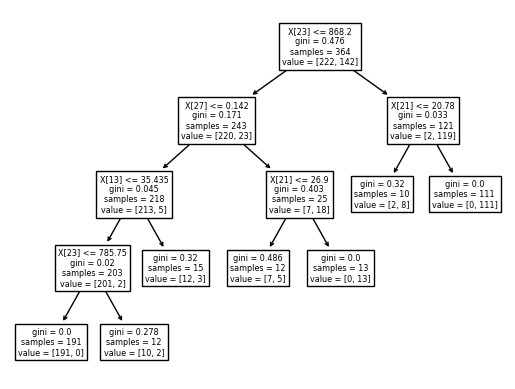

In [117]:
clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=md_optimal, 
                                 min_impurity_decrease=0.001, min_samples_leaf=10)
clf = clf.fit(wdbc_x_train, wdbc_y_train)
pred = clf.predict(wdbc_x_val)
tree.plot_tree(clf)

print("Accuracy for this model: ", metrics.accuracy_score(wdbc_y_val, pred))
print("Precision for class M: ", metrics.precision_score(wdbc_y_val, pred, pos_label='M'))
print("Recall for class M: ", metrics.recall_score(wdbc_y_val, pred, pos_label='M'))
print("F-score for this model: ", metrics.f1_score(wdbc_y_val, pred, pos_label='M'))
print("Confusion Matrix for this model: \n", metrics.confusion_matrix(wdbc_y_val, pred))

## Logistic Regression

We now look at the logistic regression model and evaluate the performance of this model using our training and validation datasets. To do this analysis, we first standardize features by removing the mean and scaling to unit variance.

In [165]:
wdbc_x_train_scalar = preprocessing.StandardScaler().fit_transform(wdbc_x_train)
wdbc_x_val_scalar = preprocessing.StandardScaler().fit_transform(wdbc_x_val)

for p in ('l1', 'l2', 'none'):
    clf = linear_model.LogisticRegression(penalty=p, solver='saga', max_iter=4000) 
    clf = clf.fit(wdbc_x_train_scalar, wdbc_y_train)
    pred = clf.predict(wdbc_x_val_scalar)
    
    print("F-score when penalty = ",p ,": ", metrics.f1_score(wdbc_y_val, pred, pos_label='M'))

F-score when penalty =  l1 :  0.9714285714285714
F-score when penalty =  l2 :  0.9577464788732395
F-score when penalty =  none :  0.927536231884058


Here, we see the f-score for L1 penalty is maximum, hence this is the best hyperparameter setting in this scenario.

## Selecting Final Model

We now compare our F-measures on the validation datasets for all the models we have built. We see that the F-score for both KNN and Logistic Regression with L1 penalty are same on the validation dataset. However, KNN supports non-linear solutions as well, and considering the same, we will take KNN as our final model. Now, we will train our model using the combination of training and validation datasets we have using till now to set hyperparameters and select models, and then calculate the final performance on our holdout dataset, i.e. the testing dataset, which has not yet been seen by our model. This will thus ensure that we are depicting the true performance of our model.

## Evaluate performance of selected model - KNN

In [163]:
# normalizing
min_max_scaler2 = preprocessing.MinMaxScaler()
wdbc_x_train_2_minmax = min_max_scaler2.fit_transform(wdbc_x_train_2)
wdbc_x_test_minmax = min_max_scaler2.transform(wdbc_x_test)

# training the classifier
clf = neighbors.KNeighborsClassifier(k_optimal)
clf = clf.fit(wdbc_x_train_2_minmax, wdbc_y_train_2)

# predictions
pred = clf.predict(wdbc_x_test_minmax)

print("Accuracy for this model: ", metrics.accuracy_score(wdbc_y_test, pred))
print("Precision for class M: ", metrics.precision_score(wdbc_y_test, pred, pos_label='M'))
print("Recall for class M: ", metrics.recall_score(wdbc_y_test, pred, pos_label='M'))
print("F-score for this model: ", metrics.f1_score(wdbc_y_test, pred, pos_label='M'))
print("Confusion Matrix for this model: \n", metrics.confusion_matrix(wdbc_y_test, pred))

Accuracy for this model:  0.9912280701754386
Precision for class M:  0.9714285714285714
Recall for class M:  1.0
F-score for this model:  0.9855072463768115
Confusion Matrix for this model: 
 [[79  1]
 [ 0 34]]
